In [1]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import concatenate, Reshape, Conv1D, MaxPool1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from code.modelhelper import *

In [2]:
NCLASS = 2
BATCH_SIZE = 150
EPOCHS = 300

In [3]:
m1 = load_model("models/dl/m1.h5")
m2 = load_model("models/dl/m2.h5")
m3 = load_model("models/dl/m3.h5")

W0912 14:53:51.080589  4484 deprecation.py:323] From c:\program files\python37\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
x_feat = np.load("data/xy/x_feat_630.npz")["arr_0"]
x_char = np.load("data/xy/x_char_onehot_45_15.npz")["arr_0"]
x_word = np.load("data/xy/x_word_45_15.npy")
y = np.load("data/xy/y_onehot_45_15.npy")

In [5]:
xf_train, xf_test, y_train, y_test = train_test_split(
    x_feat,
    y,
    test_size=0.2,
    random_state=11
)

xc_train, xc_test, y_train, y_test = train_test_split(
    x_char,
    y,
    test_size=0.2,
    random_state=11
)

xw_train, xw_test, y_train, y_test = train_test_split(
    x_word,
    y,
    test_size=0.2,
    random_state=11
)

# Models 1, 2, 3 Fusion

In [6]:
for layer in m1.layers:
    layer.trainable = False
    
for layer in m2.layers:
    layer.trainable = False
    
for layer in m3.layers:
    layer.trainable = False

In [7]:
model_input = concatenate(
    [
        m1.get_layer("m1_dense4").output,
        m2.get_layer("m2_gru_2").output,
        m3.get_layer("m3_lstm").output,
    ]
)

H = Reshape((200+256+32, 1), name="fusion_reshape")(model_input)

H = Conv1D(
    filters=32,
    kernel_size=2,
    padding="same",
    activation="tanh",
    name="fusion_conv1d_1"
)(H)
H = MaxPool1D(2, name="fusion_maxpool1d_1")(H)

H = Conv1D(
    filters=32,
    kernel_size=2,
    padding="same",
    activation="tanh",
    name="fusion_conv1d_2"
)(H)
H = MaxPool1D(2, name="fusion_maxpool1d_2")(H)

H = Conv1D(
    filters=32,
    kernel_size=2,
    padding="same",
    activation="tanh",
    name="fusion_conv1d_3"
)(H)
H = MaxPool1D(2, name="fusion_maxpool1d_3")(H)

H = Conv1D(
    filters=32,
    kernel_size=2,
    padding="same",
    activation="tanh",
    name="fusion_conv1d_4"
)(H)
H = MaxPool1D(2, name="fusion_maxpool1d_4")(H)

H = Flatten(name="fusion_flatten")(H)
H = Dense(480, activation='tanh', name="fusion_dense_1")(H)
H = Dense(120, activation='tanh', name="fusion_dense_2")(H)
model_output = Dense(NCLASS, activation='softmax', name="fusion_output")(H)

model = Model(inputs=[m1.input, m2.input, m3.input], outputs=model_output)
model.summary()

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
m2_input (InputLayer)           [(None, 13900)]      0                                            
__________________________________________________________________________________________________
m2_reshape (Reshape)            (None, 100, 139, 1)  0           m2_input[0][0]                   
__________________________________________________________________________________________________
m2_timedistributed_1 (TimeDistr (None, 100, 139, 20) 60          m2_reshape[0][0]                 
__________________________________________________________________________________________________
m2_timedistributed_2 (TimeDistr (None, 100, 69, 20)  0           m2_timedistributed_1[0][0]       
______________________________________________________________________________________________

# Training

In [8]:
history = model.fit(
    [xf_train, xc_train, xw_train],
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    validation_data=([xf_test, xc_test, xw_test], y_test),
    callbacks=[es]
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/300
48000/48000 - 93s - loss: 0.0494 - accuracy: 0.9844 - val_loss: 0.0605 - val_accuracy: 0.9797
Epoch 2/300
48000/48000 - 86s - loss: 0.0425 - accuracy: 0.9871 - val_loss: 0.0613 - val_accuracy: 0.9808
Epoch 3/300
48000/48000 - 85s - loss: 0.0416 - accuracy: 0.9868 - val_loss: 0.0586 - val_accuracy: 0.9810
Epoch 4/300
48000/48000 - 86s - loss: 0.0410 - accuracy: 0.9871 - val_loss: 0.0573 - val_accuracy: 0.9812
Epoch 5/300
48000/48000 - 86s - loss: 0.0399 - accuracy: 0.9877 - val_loss: 0.0619 - val_accuracy: 0.9801
Epoch 6/300
48000/48000 - 86s - loss: 0.0405 - accuracy: 0.9875 - val_loss: 0.0610 - val_accuracy: 0.9797
Epoch 7/300
48000/48000 - 86s - loss: 0.0404 - accuracy: 0.9874 - val_loss: 0.0582 - val_accuracy: 0.9811
Epoch 8/300
48000/48000 - 87s - loss: 0.0398 - accuracy: 0.9880 - val_loss: 0.0616 - val_accuracy: 0.9796
Epoch 9/300
48000/48000 - 86s - loss: 0.0399 - accuracy: 0.9875 - val_loss: 0.0581 - val_accuracy: 0.9

In [9]:
score = model.evaluate([xf_test, xc_test, xw_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred_model = model.predict([xf_test, xc_test, xw_test])
y_pred = to_bin(y_pred_model)
print("Test recall: {}".format(recall(y_test, y_pred)))

y_test0 = to_1D(y_test)
y_pred0 = to_1D(y_pred)
print(confusion_matrix(y_test0, y_pred0))

Test loss: 0.057318296974524854
Test accuracy: 0.98116666
Test recall: 0.9509969584319027
[[8960   81]
 [ 145 2814]]


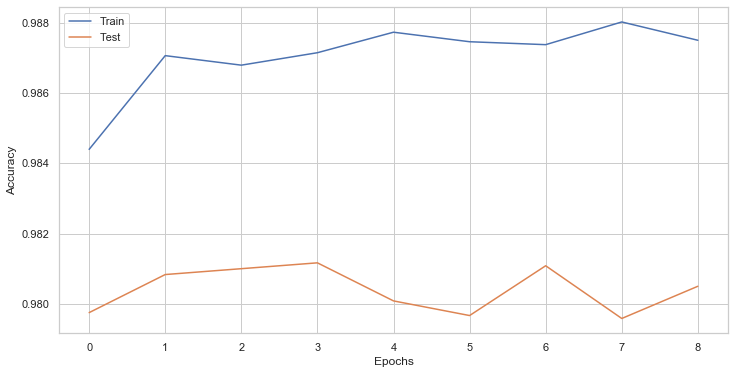

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [11]:
model.save("models/dl/fusion.h5")

# K-fold CV

In [7]:
model_params = {
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "es": es,
}

In [8]:
scores = kfold_multi_input(model, model_params, [x_feat, x_char, x_word], y, cv=10)

Starting 10-fold cross validation:
    Validation 01 of 10 ... done [896.39s]
    Validation 02 of 10 ... done [711.50s]
    Validation 03 of 10 ... done [709.41s]
    Validation 04 of 10 ... done [710.35s]
    Validation 05 of 10 ... done [606.61s]
    Validation 06 of 10 ... done [683.84s]
    Validation 07 of 10 ... done [653.07s]
    Validation 08 of 10 ... done [590.13s]
    Validation 09 of 10 ... done [859.41s]
    Validation 10 of 10 ... done [585.34s]


In [9]:
arr = scores_dict_to_array(scores)
arr

array([[0.981     , 0.98133333, 0.98983333, 0.98833333, 0.98883333,
        0.98866667, 0.99066667, 0.98916667, 0.99016667, 0.98983333],
       [0.97884344, 0.97577855, 0.9897541 , 0.98976109, 0.98371777,
        0.98762887, 0.99597315, 0.99250681, 0.98706339, 0.9929078 ],
       [0.94293478, 0.94821789, 0.96923077, 0.96345515, 0.97119893,
        0.96637525, 0.96740548, 0.96426208, 0.97507987, 0.96485183],
       [0.00662544, 0.00775537, 0.00332963, 0.00333704, 0.00532505,
        0.00398848, 0.00134348, 0.00245043, 0.00450958, 0.00219829]])

In [ ]:
np.save("cv/fusion_123_cv.npy", arr)

In [11]:
arr[2].mean()

0.9633012022729963

# Confusion Matrix

In [2]:
model = load_model("models/dl/fusion.h5")

W0918 13:54:14.077210 4669298112 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
y_pred_model = model.predict([xf_test, xc_test, xw_test])
y_pred = to_bin(y_pred_model)